# Data prepration

In [1]:
import numpy as np
import datetime
import os
import sklearn.metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from scipy.stats import chi
from scipy import stats

2022-06-29 11:43:44.684767: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-29 11:43:44.684796: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
############
# Functions
############

# Generate n data for set of thetas
def spherical_data(n, thetas, phis, rand=1234):
    
    m1 = np.transpose(np.array([np.zeros(n), np.zeros(n)]))
    v1 = np.transpose(np.array([np.ones(n), np.ones(n)]))
    mu1 = m1[0]
    cov1 = np.eye(2)
    
    mx, my = mean_gen(thetas, phis), np.zeros(n)
    m2 = np.transpose(np.array([mx, my]))
    vx, vy = varx_gen(thetas, phis), vary_gen(thetas, phis)
    v2 = np.diag(np.transpose(np.array([vx, vy])))
    
    for i in range(n):
        mu2 = m2[i]
        cov2 = np.diag(v2[i])
        x1, y1, z1 = np.random.multivariate_normal(mu1, cov1), np.zeros(n)
        x2, y2, z2 = np.random.multivariate_normal(mu1, cov1), np.zeros(n)
    
    
    
    x1, y1 = np.transpose(np.array([np.random.normal(m1, v1, size=n), thetas])), np.zeros(n)
    x2, y2 = np.transpose(np.array([np.random.normal(m2, v2, size=n), thetas])), np.ones(n)
    x, y = np.append(x1, x2, axis=0), np.append(y1, y2, axis=0)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = rand)
    
    return x_train, x_test, y_train, y_test

# x, y axes are variances, z axis is mean value
def mean_gen(theta, phi):
    mu = 0.5 + (np.sqrt(2)/2) * np.cos(phi + np.pi / 4)
    return mu

def varx_gen(theta, phi):
    vx = 1.5 - (np.sqrt(2)/2) * np.cos(theta + np.pi / 4) * np.sin(phi + np.pi / 2)
    return vx

def vary_gen(theta, phi):
    vy = 1.5 - (np.sqrt(2)/2) * np.sin(theta + np.pi / 4) * np.sin(phi + np.pi / 2)
    return vy

def discrete_thetas(n, m):
    xk = np.arange(m)
    pk = (1 / m) * np.ones(int(m))
    discrete_distr = stats.rv_discrete(name='discrete_distr', values=(xk, pk))
    thetas = discrete_distr.rvs(size=n) / (m / 6)
    return thetas

In [14]:
n = 30000
thetas = np.pi / 6 * np.ones(n)
phis = np.zeros(n)

mx, my = mean_gen(thetas, phis), np.zeros(n)
m = np.transpose(np.array([mx, my]))

vx, vy = varx_gen(thetas, phis), vary_gen(thetas, phis)
v = np.transpose(np.array([vx, vy]))

np.random.multivariate_normal(m[0],np.diag(v[0]))

array([1.23408587, 0.27982498])

# Uniform Distribution of Thetas
n = 100000
rand_n = 1234
thetas = np.random.uniform(0, 2 * np.pi, n)


x_train, x_test, y_train, y_test = theta_data(n, thetas, rand_n)

In [10]:
# Discrete Distribution of Thetas
m = 3
thetas = discrete_thetas(n, m)
x_train, x_test, y_train, y_test = theta_data(n, thetas, rand_n)

# Training Interpolated Model

In [11]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
]);

loss_fn = tf.keras.losses.BinaryCrossentropy()
model.compile(
    optimizer='adam',
    loss=loss_fn,
    metrics=['accuracy']
)

batch_size = 1000

checkpoint_path = "tutorial/checkpoints/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    verbose=1,
    save_freq=10*batch_size
)

log_dir = "tutorial/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

EPOCHS=10
model.fit(
    x_train, y_train, epochs=EPOCHS,
    batch_size=batch_size,
    callbacks=[cp_callback, tensorboard_callback]
);

model.save('models/interpolated_model_discrete%.0f' %(m))

2022-06-16 12:21:26.518003: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-06-16 12:21:26.518033: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-06-16 12:21:26.518083: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/10
 27/160 [====>.........................] - ETA: 0s - loss: 0.6534 - accuracy: 0.5953

2022-06-16 12:21:26.960247: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-06-16 12:21:26.960279: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-06-16 12:21:26.979304: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-06-16 12:21:26.980162: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-06-16 12:21:26.992892: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: tutorial/logs/20220616-122126/train/plugins/profile/2022_06_16_12_21_26

2022-06-16 12:21:26.999000: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to tutorial/logs/20220616-122126/train/plugins/profile/2022_06_16_12_21_26/jupyter-matan.trace.json.gz
2022-06-16 12:21:27.000601: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: tutorial/logs/20220616-122

160/160 [==============================] - 1s 4ms/step - loss: 0.6330 - accuracy: 0.6139
Epoch 2/10
160/160 [==============================] - 1s 4ms/step - loss: 0.6194 - accuracy: 0.6265
Epoch 3/10
160/160 [==============================] - 1s 4ms/step - loss: 0.6148 - accuracy: 0.6281
Epoch 4/10
160/160 [==============================] - 1s 4ms/step - loss: 0.6138 - accuracy: 0.6296
Epoch 5/10
160/160 [==============================] - 1s 4ms/step - loss: 0.6134 - accuracy: 0.6298
Epoch 6/10
160/160 [==============================] - 1s 4ms/step - loss: 0.6129 - accuracy: 0.6295
Epoch 7/10
160/160 [==============================] - 1s 4ms/step - loss: 0.6130 - accuracy: 0.6297
Epoch 8/10
160/160 [==============================] - 1s 4ms/step - loss: 0.6125 - accuracy: 0.6295
Epoch 9/10
160/160 [==============================] - 1s 4ms/step - loss: 0.6127 - accuracy: 0.6298
Epoch 10/10
160/160 [==============================] - 1s 4ms/step - loss: 0.6128 - accuracy: 0.6291
INFO:tenso

In [16]:
model = tf.keras.models.load_model('3dmodels/interpolated_model_discrete%.0f' %(m))

In [6]:
# Model Classification Predictions
predictions = np.round(model(x_test).numpy())

# Separate Data into bins based on variance
theta_max = 2 * np.pi
theta_min = 0
epsilon = 0.5
bins = int((theta_max - theta_min) / (2 * epsilon))
var_list = np.arange(theta_min + epsilon, theta_max + epsilon, 2 * epsilon)

test_binned, x_test_bin, y_test_bin = [], [], []
for i in range(bins):
    c = var_list[i]
    test_binned.append(np.array([(x, t, y) for (x, t, y) in zip(x_test[:, 0], x_test[:, 1], y_test) if np.abs(t - c) < epsilon]))
    x_test_bin.append(np.array(test_binned[i][:, 0:2]))
    y_test_bin.append(np.array(test_binned[i][:, 2]))



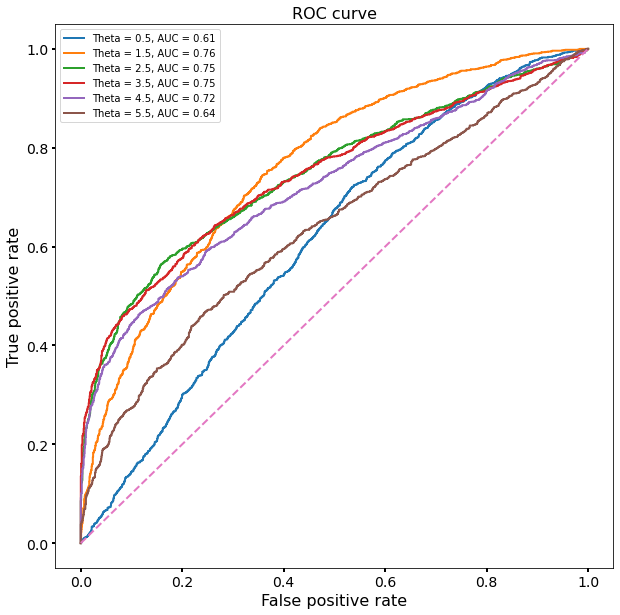

In [7]:
fig, ax1 = plt.subplots(figsize=(10,10))
fontsize=16
minor_size=14

for i in range(bins):
    x_test = x_test_bin[i]
    y_test = y_test_bin[i]
    predictions = model(x_test).numpy()
    fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, predictions)
    auc = sklearn.metrics.auc(fpr, tpr)
    ax1.plot(fpr, tpr, lw=2, label='Theta = %.1f, AUC = %.2f' % (var_list[i], auc))

ax1.plot([0, 1], [0, 1], '--', lw=2)
ax1.set_xlabel('False positive rate', fontsize=fontsize)
ax1.set_ylabel('True positive rate', fontsize=fontsize)
ax1.set_title('ROC curve', fontsize=fontsize)
ax1.legend()
ax1.tick_params(width=2, grid_alpha=0.5, labelsize=minor_size)